In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timeit
import time

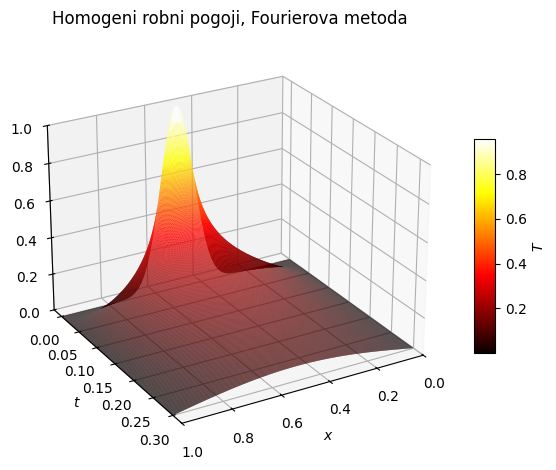

In [2]:
a = 1
x_0 = a/2
sigma = a/10
t_max = 0.3

N_default = 100
x = np.linspace(0, a, 3*N_default)
t = np.linspace(0, t_max, 3*N_default)
T_0 = np.exp(-(x - x_0)**2/(sigma**2))

h_x = np.diff(x)[0]
h_t = np.diff(t)[0]

# Začetni pogoj na robu
T_0[0] = 0
T_0[-1] = 0

# Fourierova metoda

def hom_fourier_sol_(T_0, t, h_x, h_t, D=0.5):
    N = 2 * len(T_0)
    T_0 = np.concatenate((-T_0, T_0))
    t = np.linspace(0, 2*np.max(t), N)
    T_new = np.zeros((N, N), dtype=complex)
    fft_T_0 = np.fft.fft(T_0)
    k = np.fft.fftfreq(N, d=h_x)
    for i in range(N):
        T_new[:, i] = np.exp(-4. * D * t * np.pi**2. * k[i]**2.) * fft_T_0[i]
    for j in range(N):
        T_new[j, :] = np.fft.ifft(T_new[j, :])
    T_new = T_new[:N//2,N//2:]
    T_new = T_new.real
    return T_new

sol_f = hom_fourier_sol_(T_0, t, h_x, h_t)
x, t = np.meshgrid(x, t)
fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(x, t, sol_f, rstride=1, cstride=1, cmap='hot', edgecolor='none')
ax.set_xlim(0, a)
ax.set_zlim(0, 1)
ax.set_title("Homogeni robni pogoji, Fourierova metoda")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.set_zlabel("$T$")
ax.view_init(25, 60)
cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cb.set_label("$T$")
plt.tight_layout()
plt.show()

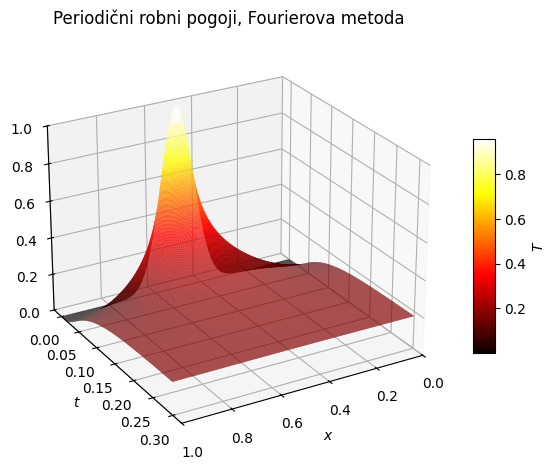

In [3]:
a = 1
x_0 = a/2
sigma = a/10
t_max = 0.3

N_default = 100
x = np.linspace(0, a, 3*N_default)
t = np.linspace(0, t_max, 3*N_default)
T_0 = np.exp(-(x - x_0)**2/(sigma**2))

h_x = np.diff(x)[0]
h_t = np.diff(t)[0]

# Začetni pogoj na robu
T_0[0] = 0
T_0[-1] = 0

# Fourierova metoda

def hom_fourier_sol_(T_0, t, h_x, h_t, D=0.5):
    N = len(T_0)
    T_new = np.zeros((N, N), dtype=complex)
    fft_T_0 = np.fft.fft(T_0)
    k = np.fft.fftfreq(N, d=h_x)
    for i in range(N):
        T_new[:, i] = np.exp(-4. * D * t * np.pi**2. * k[i]**2.) * fft_T_0[i]
    for j in range(N):
        T_new[j, :] = np.fft.ifft(T_new[j, :])
    T_new = T_new.real
    return T_new

sol_p = hom_fourier_sol_(T_0, t, h_x, h_t)
x, t = np.meshgrid(x, t)
fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(x, t, sol_p, rstride=1, cstride=1, cmap='hot', edgecolor='none')
ax.set_xlim(0, a)
ax.set_zlim(0, 1)
ax.set_title("Periodični robni pogoji, Fourierova metoda")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.set_zlabel("$T$")
ax.view_init(25, 60)
cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cb.set_label("$T$")
plt.tight_layout()
plt.show()

In [ ]:
def B_k(delta, k, x0):
    term1 = x0 - delta * (k - 2)
    term2 = x0 - delta * (k - 1)
    term3 = x0 - delta * k
    term4 = x0 - delta * (k + 1)
    term5 = x0 - delta * (k + 2)

    if x0 <= delta * (k - 2):
        return 0.0
    elif x0 <= delta * (k - 1):
        return (term1 ** 3) / (delta ** 3)
    elif x0 <= delta * k:
        return (term1 ** 3) / (delta ** 3) - 4 * (term2 ** 3) / (delta ** 3)
    elif x0 <= delta * (k + 1):
        return 4 * (term4 ** 3) / (delta ** 3) - (term5 ** 3) / (delta ** 3)
    elif x0 <= delta * (k + 2):
        return -(term5 ** 3) / (delta ** 3)
    else:
        return 0.0

def spline_sol(x_0, t, x, D=0.5, a=1.):
    t1 = time.time()
    N = len(x)
    t_max = t[-1]
    dx = a/N
    dt = t_max/N

    main_diagonal_A = 4 * np.ones(N)
    off_diagonal_A = np.ones(N - 1)
    A = np.diag(main_diagonal_A, 0) + np.diag(off_diagonal_A, -1) + np.diag(off_diagonal_A, 1)

    main_diagonal_B = -2 * np.ones(N)
    off_diagonal_B = np.ones(N - 1)
    B = 6 * D / dx**2 * (np.diag(main_diagonal_B, 0) + np.diag(off_diagonal_B, -1) + np.diag(off_diagonal_B, 1))

    C = np.linalg.inv(A - dt / 2 * B) @ (A + dt / 2 * B)

    c0 = np.linalg.solve(A, x_0)
    
    T = []
    for t_ in t:
        if t_ == 0:
            c = c0
        c = C@c
        T_xs = []
        for xi in range(len(x)):
            T_x = 0
            for k in range(xi-1,N+2):
                if k == -1:
                    c_k = -c[1]
                elif k == 0 or k == N:
                    c_k = 0
                elif k == N+1:
                    c_k = -c[N-1]
                else:
                    c_k = c[k]
                T_x += c_k*B_k(dx, k, x[xi])
            T_xs.append(T_x)
        T.append(T_xs)
    T = np.array(T)
    T = np.concatenate((np.array([x_0]), T[:-1]))
    dt = time.time() - t1
    return T, dt

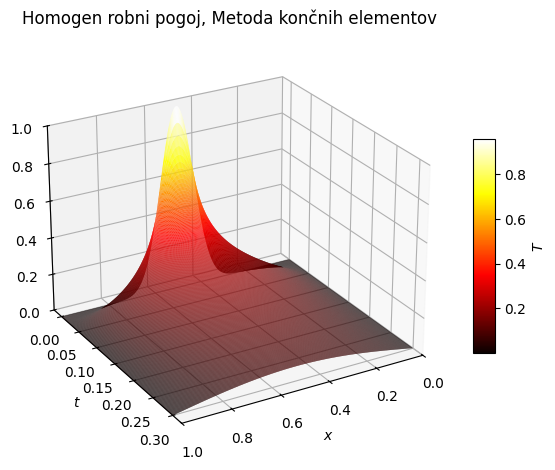

In [9]:
a = 1
x_0 = a/2
sigma = a/10
t_max = 0.3

N_default = 100
x = np.linspace(0, a, 3*N_default)
t = np.linspace(0, t_max, 3*N_default)
T_0 = np.exp(-(x - x_0)**2/(sigma**2))

h_x = np.diff(x)[0]
h_t = np.diff(t)[0]

T_0[0] = 0
T_0[-1] = 0

sol = spline_sol(T_0, t, x)
x, t = np.meshgrid(x, t)
fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(x, t, sol[0], rstride=1, cstride=1, cmap='hot', edgecolor='none')
ax.set_xlim(0, a)
ax.set_zlim(0, 1)
ax.set_title("Homogen robni pogoj, Metoda končnih elementov")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.set_zlabel("$T$")
ax.view_init(25, 60)
cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cb.set_label("$T$")
plt.tight_layout()
plt.show()

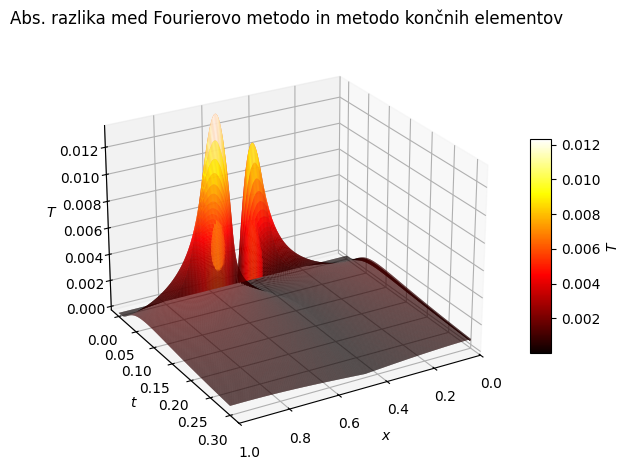

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(x, t, np.abs(sol[0] - sol_f), rstride=1, cstride=1, cmap='hot', edgecolor='none')
ax.set_xlim(0, a)
ax.set_title("Abs. razlika med Fourierovo metodo in metodo končnih elementov")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
ax.set_zlabel("$T$")
ax.view_init(25, 60)
cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cb.set_label("$T$")
plt.tight_layout()
plt.show()

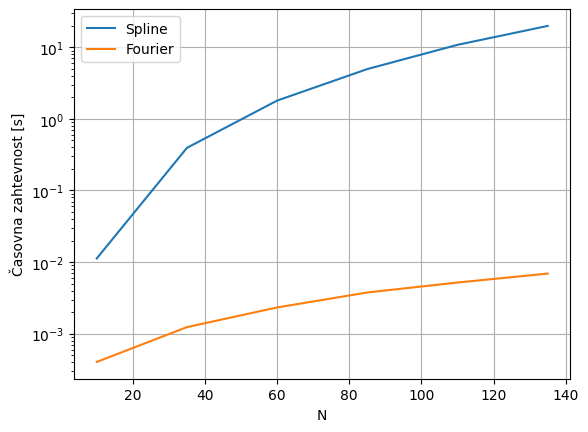

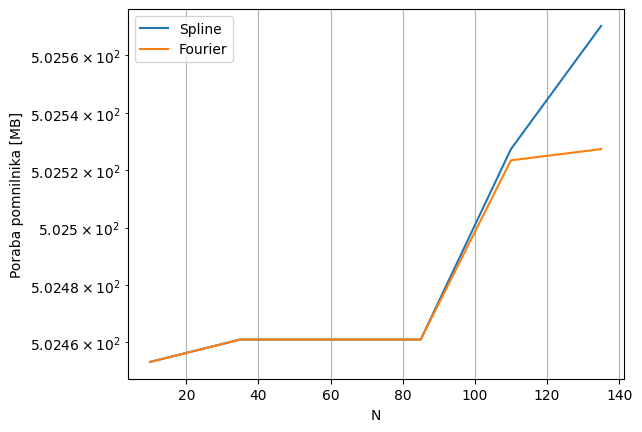

In [7]:
import psutil
def measure_performance(func, *args):
    start_time = time.time()
    result = func(*args)
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Measure memory usage
    process = psutil.Process()
    memory_info = process.memory_info()
    memory_usage = memory_info.rss / 1024 / 1024  # in MB
    
    return result, execution_time, memory_usage

a = 1
x_0 = a/2
sigma = a/10
t_max = 0.3

spline_res = []
fourier_res = []

import gc

NS = range(10, 150, 25)
for N_default in NS:
    x = np.linspace(0, a, 3*N_default)
    t = np.linspace(0, t_max, 3*N_default)
    T_0 = np.sin(np.pi*x/a)

    h_x = np.diff(x)[0]
    h_t = np.diff(t)[0]

    T_0[0] = 0
    T_0[-1] = 0

    gc.collect()
    sol2, time2, memory2 = measure_performance(hom_fourier_sol_, T_0, t, h_x, h_t)
    fourier_res.append((sol2, time2, memory2))


    gc.collect()
    sol, time_, memory_ = measure_performance(spline_sol, T_0, t, x)
    spline_res.append((sol, time_, memory_))

# Plot execution time
plt.plot(NS, [res[1] for res in spline_res], label="Spline")
plt.plot(NS, [res[1] for res in fourier_res], label="Fourier")
plt.xlabel("N")
plt.ylabel("Časovna zahtevnost [s]")
plt.legend()
plt.grid()
plt.yscale("log")
plt.show()

# Plot memory usage
plt.plot(NS, [res[2] for res in spline_res], label="Spline")
plt.plot(NS, [res[2] for res in fourier_res], label="Fourier")
plt.xlabel("N")
plt.ylabel("Poraba pomnilnika [MB]")
plt.legend()
plt.grid()
plt.yscale("log")
plt.show()
